In [1]:
import scvelo as scv
import numpy as np
import random
import torch
import scanpy as sc
from scvelo.preprocessing.moments import get_moments

from InterVelo.train import train, Constants
from InterVelo._utils import update_dict, autoset_coeff_s
from InterVelo.data import preprocess_data



In [4]:
#Setting appropriate initial values can help estimate pseudotime. 
#As the velocity direction is more stable than pseudotime, we suggest taking it as the references
#If the pseudotime is inconsistent with the velocity direction, try changing the random seed.
SEED = 123
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

adata = scv.datasets.pancreas()
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
sc.pp.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
adata = preprocess_data(adata, layers=["Ms","Mu"], filter_on_r2=False)
#spliced = csr_matrix(adata.layers["spliced"]).astype(np.float32).A
spliced = torch.tensor(adata.layers["Ms"])
unspliced = torch.tensor(adata.layers["Mu"])
inputdata=torch.cat([spliced,unspliced],dim=1)

configs = {
        "name": "InterVelo", # name of the experiment
        "loss_pearson": {"coeff_s": autoset_coeff_s(adata)}  ,# Automatic setting of the spliced correlation objective
        "arch": {"args": {"pred_unspliced": False,
				#"scale1":1,   # Changing the sign of scale1 can help control the direction of pseudotime.
				}},
    	}
configs = update_dict(Constants.default_configs, configs)

import time

start_time = time.time()

trainer = train(adata, inputdata, configs)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Intervelo: {elapsed_time:.2f} seconds")

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Filtered out 0 genes according to linear regression fit.
The ratio of spliced reads is 83.2% (between 70% and 85%). Suggest using coeff_s 0.75.


INFO:train:Beginning training of InterVelo ...
INFO:trainer:    epoch          : 1
INFO:trainer:    time:          : 28.46504020690918
INFO:trainer:    loss           : 953.5984497070312
INFO:trainer:    val_loss       : 706.9130859375
INFO:trainer:    epoch          : 2
INFO:trainer:    time:          : 26.121241569519043
INFO:trainer:    loss           : 692.8169860839844
INFO:trainer:    val_loss       : 650.3037109375
INFO:trainer:    epoch          : 3
INFO:trainer:    time:          : 26.455501317977905
INFO:trainer:    loss           : 623.4689636230469
INFO:trainer:    val_loss       : 585.3336181640625
INFO:trainer:    epoch          : 4
INFO:trainer:    time:          : 29.22217893600464
INFO:trainer:    loss           : 569.7866058349609
INFO:trainer:    val_loss       : 519.2808837890625
INFO:trainer:    epoch          : 5
INFO:trainer:    time:          : 28.537338733673096
INFO:trainer:    loss           : 498.6878204345703
INFO:trainer:    val_loss       : 431.8096923828

Reverse pseudotime and velocity for the negative direction loss.
velo_mat shape: (3696, 2000)
--> added 'velocity' (adata.layers)
--> added 'pseudotime'(adata.obs)
--> added 'X_TNODE'(adata.obsm)
--> added 'X_VF'(adata.obsm)
--> added 'pred_beta' (adata.var)
--> added 'pred_gamma' (adata.var)
computing velocity graph (using 10/192 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:47) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
--> added 'velocity_pseudotime'(adata.obs)
--> model scale1: Parameter containing:
tensor(0.5196, requires_grad=True)
--> model scale2: Parameter containing:
tensor(1., requires_grad=True)
Intervelo: 2756.88 seconds


In [5]:
adata

AnnData object with n_obs × n_vars = 3696 × 2000
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'pseudotime', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime'
    var: 'highly_variable_genes', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'pred_beta', 'pred_gamma'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'X_umap', 'X_TNODE', 'X_VF'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity'
    obsp: 'distances', 'connectivities'

In [6]:
adata.obs['velocity_pseudotime']

index
AAACCTGAGAGGGATA    0.852704
AAACCTGAGCCTTGAT    0.159336
AAACCTGAGGCAATTA    0.892232
AAACCTGCATCATCCC    0.004447
AAACCTGGTAAGTGGC    0.706381
                      ...   
TTTGTCAAGTGACATA    0.820761
TTTGTCAAGTGTGGCA    0.570385
TTTGTCAGTTGTTTGG    0.158520
TTTGTCATCGAATGCT    0.997027
TTTGTCATCTGTTTGT    0.959156
Name: velocity_pseudotime, Length: 3696, dtype: float64

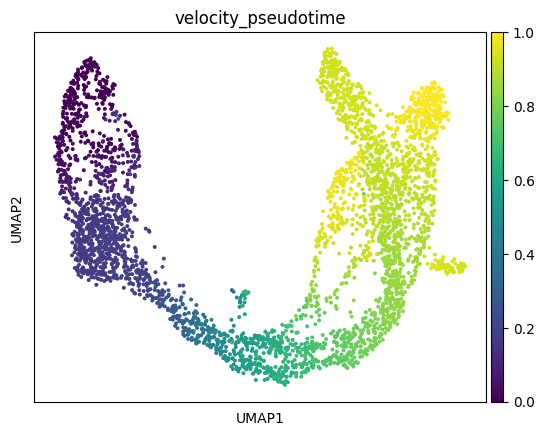

In [7]:
sc.pl.umap(adata, color='velocity_pseudotime')

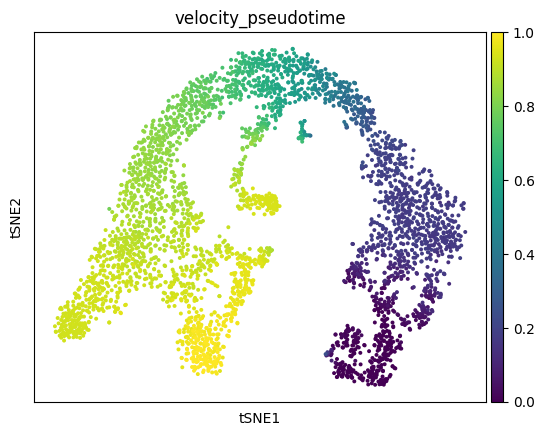

In [9]:
sc.tl.tsne(adata)
sc.pl.tsne(adata, color='velocity_pseudotime')

In [12]:
sc.tl.leiden(adata)

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_tsne', embedded velocity vectors (adata.obsm)


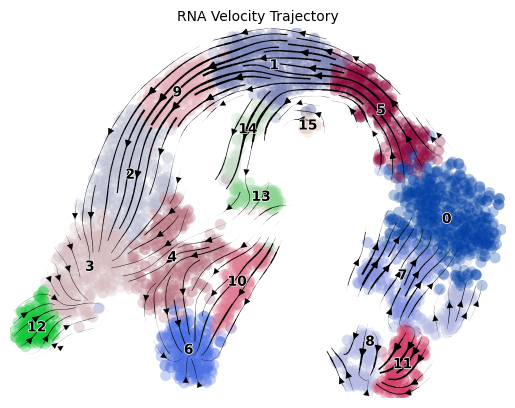

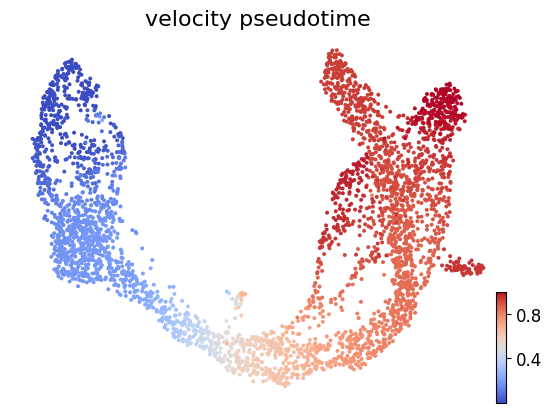

In [15]:
# 绘制RNA速度轨迹
scv.pl.velocity_embedding_stream(adata, basis='tsne', 
                                 color='leiden', 
                                 title='RNA Velocity Trajectory',
                                 dpi=100)

# 结合伪时间
scv.pl.scatter(adata, color=['velocity_pseudotime'], 
               fontsize=16, color_map='coolwarm', 
               perc=[2, 98])

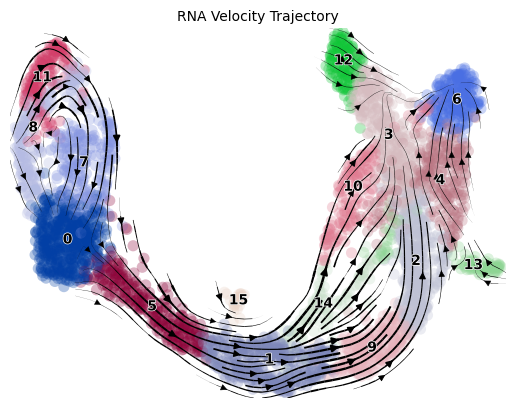

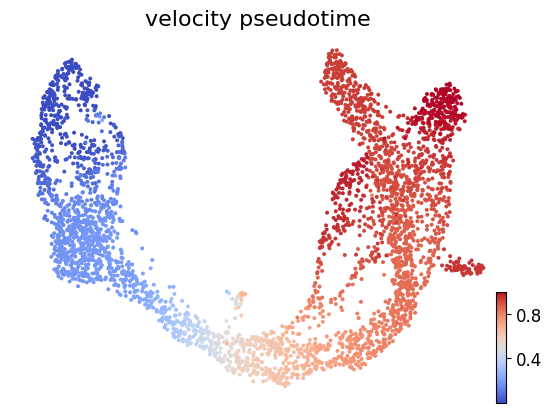

In [16]:
# 绘制RNA速度轨迹
scv.pl.velocity_embedding_stream(adata, basis='umap', 
                                 color='leiden', 
                                 title='RNA Velocity Trajectory',
                                 dpi=100)

# 结合伪时间
scv.pl.scatter(adata, color=['velocity_pseudotime'], 
               fontsize=16, color_map='coolwarm', 
               perc=[2, 98])

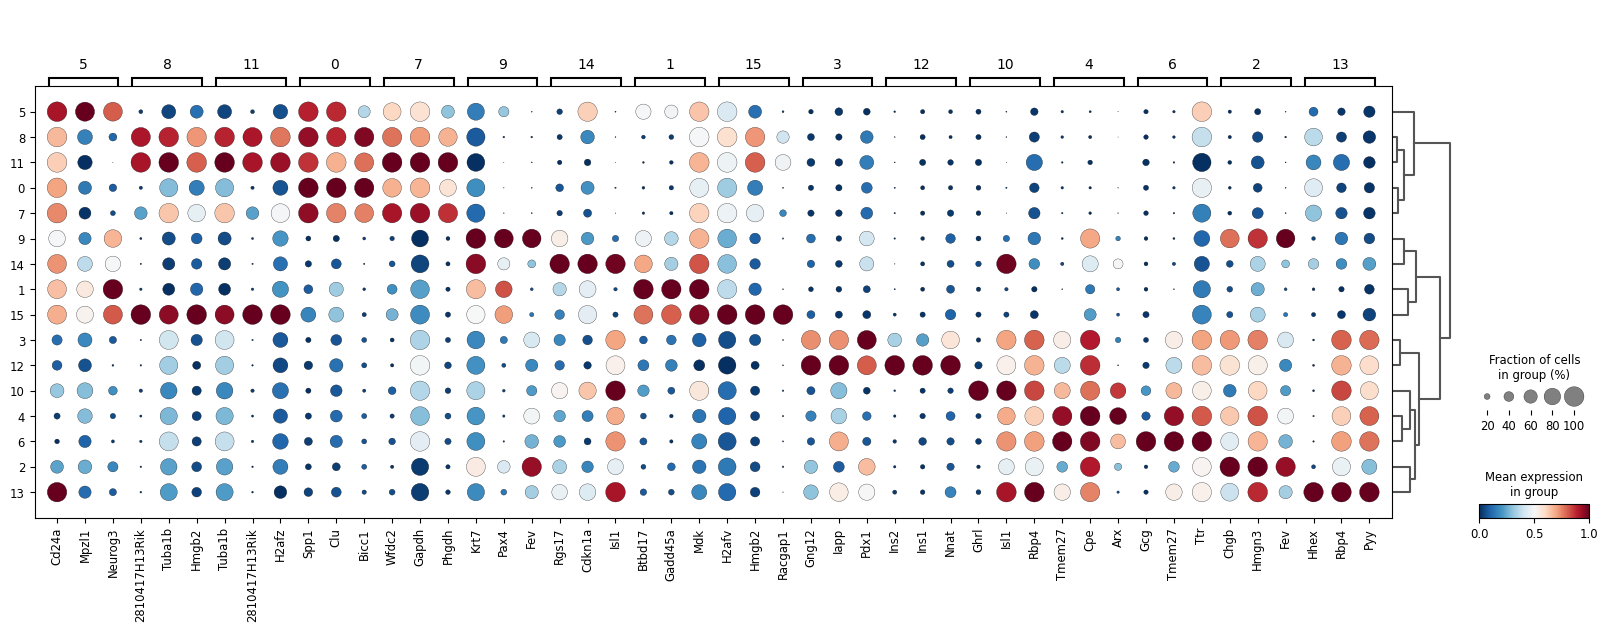

In [27]:
sc.tl.dendrogram(adata, groupby='leiden')
if 'rank_genes_groups' not in adata.uns:
    # 进行差异表达分析
    sc.tl.rank_genes_groups(adata, groupby='leiden', 
                           method='wilcoxon', 
                           use_raw=False)
sc.pl.rank_genes_groups_dotplot(adata, n_genes=3, groupby='leiden', standard_scale='var', cmap='RdBu_r',)

## Biosignificance

In [30]:
import seaborn as sns
import pandas as pd

In [35]:
adata.var_names

Index(['Sntg1', 'Snhg6', 'Ncoa2', 'Sbspon', 'Ube2w', 'Mcm3', 'Fam135a',
       'Adgrb3', 'Tmem131', 'Tbc1d8',
       ...
       'Sh3kbp1', 'Map3k15', 'Rai2', 'Rbbp7', 'Ap1s2', 'Tmem27', 'Uty',
       'Ddx3y', 'Eif2s3y', 'Erdr1'],
      dtype='object', name='index', length=2000)

In [36]:
'Surf4' in adata.var_names

True

In [44]:
print(adata.X[1:5 , 1:5])

  (0, 0)	0.3327278
  (2, 2)	0.33360565
  (3, 0)	0.42472324


In [50]:
adata.layers

Layers with keys: spliced, unspliced, Ms, Mu, velocity

In [46]:
df_surf4 = pd.concat([pd.DataFrame(adata[:, ['Surf4']].X.toarray(), index=adata.obs_names, columns=['Surf4']), adata.obs['velocity_pseudotime']], axis=1)
df_surf4

,Surf4,velocity_pseudotime
index,,
AAACCTGAGAGGGATA,0.376143,0.852704
AAACCTGAGCCTTGAT,0.000000,0.159336
AAACCTGAGGCAATTA,0.000000,0.892232
AAACCTGCATCATCCC,0.257067,0.004447
AAACCTGGTAAGTGGC,0.372437,0.706381
...,...,...
TTTGTCAAGTGACATA,0.238349,0.820761
TTTGTCAAGTGTGGCA,0.284982,0.570385
TTTGTCAGTTGTTTGG,0.000000,0.158520


<AxesSubplot:xlabel='velocity_pseudotime', ylabel='Surf4'>

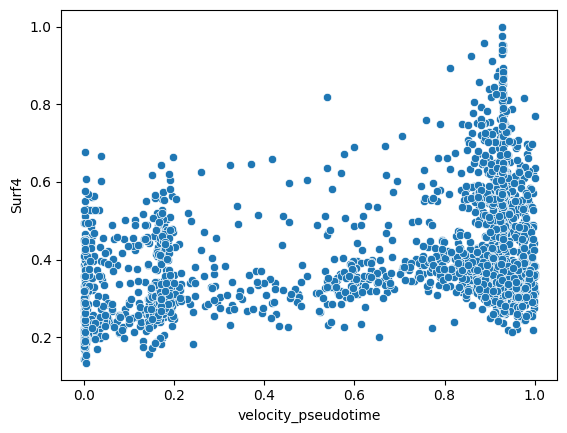

In [48]:
sns.scatterplot(data=df_surf4[df_surf4['Surf4'] > 0], x='velocity_pseudotime', y='Surf4')

<AxesSubplot:xlabel='velocity_pseudotime', ylabel='Ece1'>

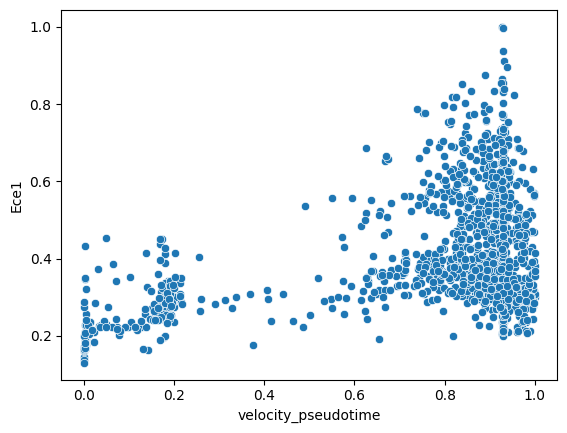

In [51]:
df_Ece1 = pd.concat([pd.DataFrame(adata[:, ['Ece1']].X.toarray(), index=adata.obs_names, columns=['Ece1']), adata.obs['velocity_pseudotime']], axis=1)

sns.scatterplot(data=df_Ece1[df_Ece1['Ece1'] > 0], x='velocity_pseudotime', y='Ece1')

<AxesSubplot:xlabel='velocity_pseudotime', ylabel='Litaf'>

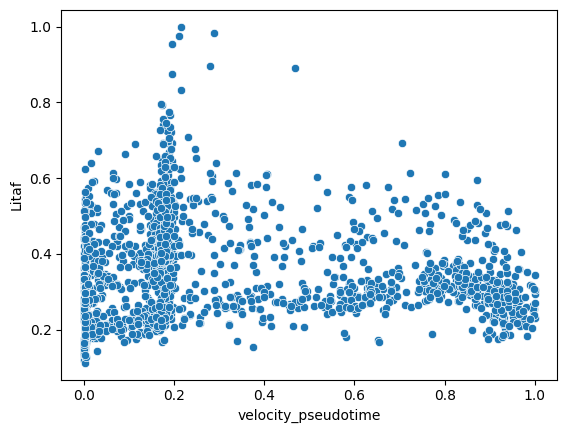

In [52]:
df_Litaf = pd.concat([pd.DataFrame(adata[:, ['Litaf']].X.toarray(), index=adata.obs_names, columns=['Litaf']), adata.obs['velocity_pseudotime']], axis=1)

sns.scatterplot(data=df_Litaf[df_Litaf['Litaf'] > 0], x='velocity_pseudotime', y='Litaf')

<AxesSubplot:xlabel='velocity_pseudotime', ylabel='Hmgb2'>

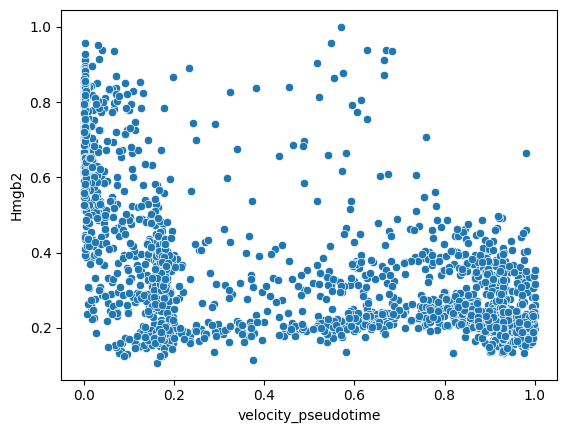

In [54]:
df_Hmgb2 = pd.concat([pd.DataFrame(adata[:, ['Hmgb2']].X.toarray(), index=adata.obs_names, columns=['Hmgb2']), adata.obs['velocity_pseudotime']], axis=1)

sns.scatterplot(data=df_Hmgb2[df_Hmgb2['Hmgb2'] > 0], x='velocity_pseudotime', y='Hmgb2')

In [59]:
adata.var_names

Index(['Sntg1', 'Snhg6', 'Ncoa2', 'Sbspon', 'Ube2w', 'Mcm3', 'Fam135a',
       'Adgrb3', 'Tmem131', 'Tbc1d8',
       ...
       'Sh3kbp1', 'Map3k15', 'Rai2', 'Rbbp7', 'Ap1s2', 'Tmem27', 'Uty',
       'Ddx3y', 'Eif2s3y', 'Erdr1'],
      dtype='object', name='index', length=2000)

## Nx

In [61]:
from importlib import reload
reload(scv.pl)

<module 'scvelo.pl' from '/home/qukungroup/syuqiao22/miniconda3/envs/P38C_TFvelo/lib/python3.8/site-packages/scvelo/pl.py'>

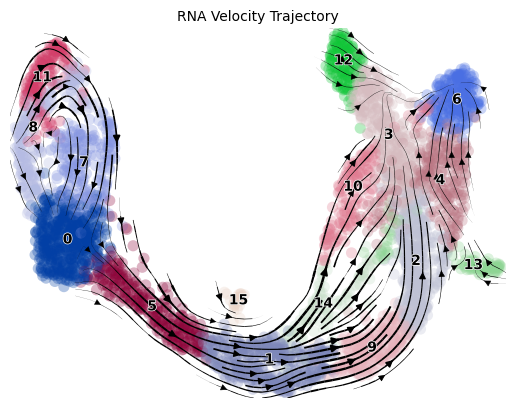

In [62]:
scv.pl.velocity_embedding_stream(adata, basis='umap', 
                                 color='leiden', 
                                 title='RNA Velocity Trajectory',
                                 dpi=100)

In [63]:
adata.write('TFvelo_revealing/Intervelo.h5ad')